In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from cycler import cycler
import scipy.stats as stats
import numpy.random  as rng
import pingouin

In [2]:
# read dataset
dfe = pd.read_csv('r490.csv')

# Correlations

In [3]:
# compute spearman correlations
parameters = ['r1_temp', 'r2_temp', 'r1_pressure', 'r2_pressure']
outputs = ['process_ron', 'process_yield']
subdf = dfe[parameters + outputs]
r = subdf.corr(method='spearman')
subdf = r.loc[parameters, outputs].copy()
columns = [(o, 'Spearman') for o in outputs]
subdf.columns = columns
subdf

,"(process_ron, Spearman)","(process_yield, Spearman)"
r1_temp,-0.098581,0.093547
r2_temp,0.030167,-0.987883
r1_pressure,-0.019149,0.016077
r2_pressure,0.001129,0.001069


In [4]:
# distance correlations
rows = []
for parameter in parameters:
    row = {
        'parameter' : parameter
    }
    for output in outputs:
        a = np.array(dfe[parameter])
        b = np.array(dfe[output])
        dcor = pingouin.distance_corr(a, b, n_boot=None)
        print("%s %s: dcor = %8.4f" % (parameter, output, dcor)) 
        row[(output, 'dCor')] = dcor
    rows.append(row)
dCorrdf = pd.DataFrame(rows).set_index('parameter')
dCorrdf

r1_temp process_ron: dcor =   0.1651
r1_temp process_yield: dcor =   0.1337
r2_temp process_ron: dcor =   0.5344
r2_temp process_yield: dcor =   0.9784
r1_pressure process_ron: dcor =   0.0159
r1_pressure process_yield: dcor =   0.0146
r2_pressure process_ron: dcor =   0.0018
r2_pressure process_yield: dcor =   0.0011


,"(process_ron, dCor)","(process_yield, dCor)"
parameter,,
r1_temp,0.165130,0.133740
r2_temp,0.534372,0.978433
r1_pressure,0.015915,0.014555
r2_pressure,0.001757,0.001113


In [8]:
# final table
corrdf = pd.concat((dCorrdf, subdf), axis=1)
corrdf.columns = pd.MultiIndex.from_tuples(corrdf.columns)
corrdf.to_csv("tmp/table1.csv")
corrdf.round(2)

,process_ron,process_yield,process_ron,process_yield
,dCor,dCor,Spearman,Spearman
r1_temp,0.17,0.13,-0.10,0.09
r2_temp,0.53,0.98,0.03,-0.99
r1_pressure,0.02,0.01,-0.02,0.02
r2_pressure,0.00,0.00,0.00,0.00


# R1 Temperature Analysis

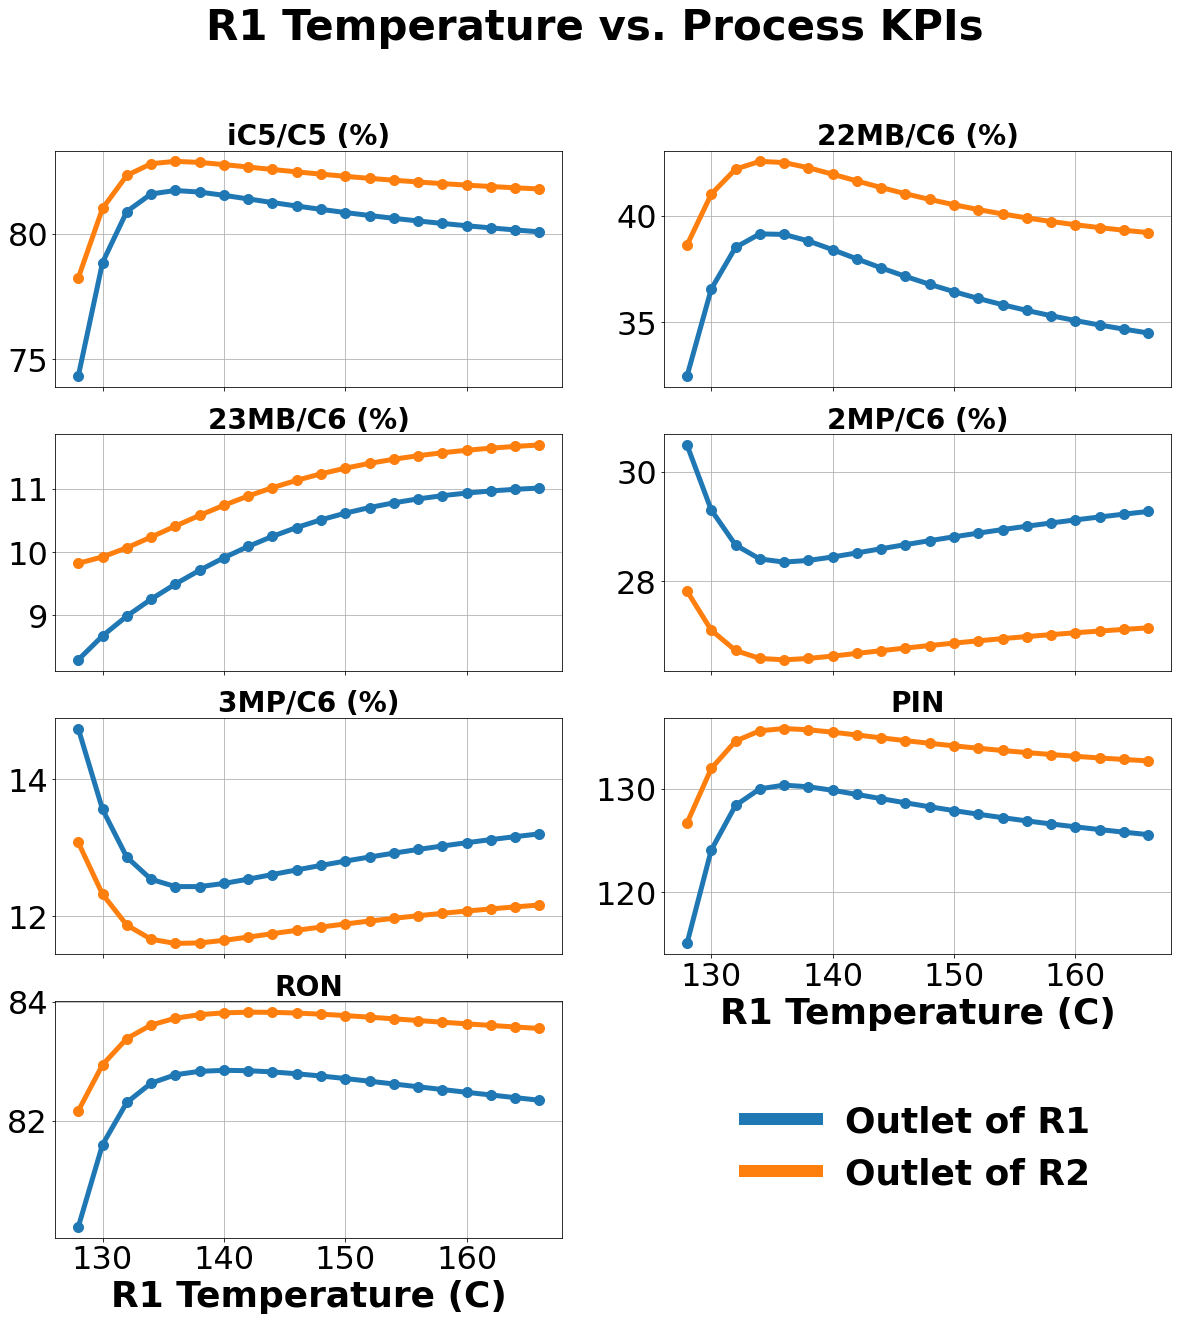

In [5]:
R2_TEMPERATURE = 128
R1_PRESSURE = 50
R2_PRESSURE = 50

sweep_col = 'r1_temp'
sweep_col_title = 'R1 Temperature (C)'
ix = (dfe['r2_temp'] == R2_TEMPERATURE) & (dfe['r1_pressure'] == R1_PRESSURE) & (dfe['r2_pressure'] == R2_PRESSURE)
sdf = dfe[ix].copy()
sdf.sort_values([sweep_col], inplace=True)

cols_to_plot = [
    ("iso_ratio_c5", "iC5/C5 (%)"),
    ("iso_ratio_c6_22mb", "22MB/C6 (%)"),
    ("iso_ratio_c6_23mb", "23MB/C6 (%)"),
    ("iso_ratio_c6_2mp", "2MP/C6 (%)"),
    ("iso_ratio_c6_3mp", "3MP/C6 (%)"),
    ("pin", "PIN"),
    ("ron", "RON")
]
n = len(cols_to_plot)

f, axes = plt.subplots(int(np.ceil(n / 2)), 2, figsize=(20, 20))
axes = axes.flatten()
for i, r in enumerate(zip(cols_to_plot, axes)):
    col_to_plot, ax = r
    col, title = col_to_plot
    ax.plot(sdf[sweep_col], sdf['r1_%s' % col], linewidth=5, marker='o', markersize=10, label='Outlet of R1')
    ax.plot(sdf[sweep_col], sdf['r2_%s' % col], linewidth=5, marker='o', markersize=10, label='Outlet of R2')
    ax.tick_params(axis='x', labelsize=32)
    ax.tick_params(axis='y', labelsize=32)
    
    if i >= 5:
        ax.set_xlabel(sweep_col_title, fontsize=36, fontweight='bold')
    else:
        ax.set_xticklabels([])
    
    if i == 5:
        # Put a legend below current axis
        legend = ax.legend(loc='upper center', 
                  frameon=False,
                  bbox_to_anchor=(0.5, -.5),
                  fancybox=False, 
                  shadow=False,
                  ncol=1,
                  prop={'weight':'bold', 'size':36})
        for line in legend.get_lines():
            line.set_linewidth(12.0)
    ax.set_title(title, fontsize=28, fontweight='bold')
    ax.grid(True)
axes[-1].axis('off')
plt.suptitle('R1 Temperature vs. Process KPIs', fontsize=42, fontweight='bold')
plt.savefig("tmp/fig3.tiff", bbox_inches='tight', transparent=True, pad_inches=0, dpi=300, pil_kwargs={"compression": "tiff_lzw"})

# Production Proportions as Function of R1 Temperature

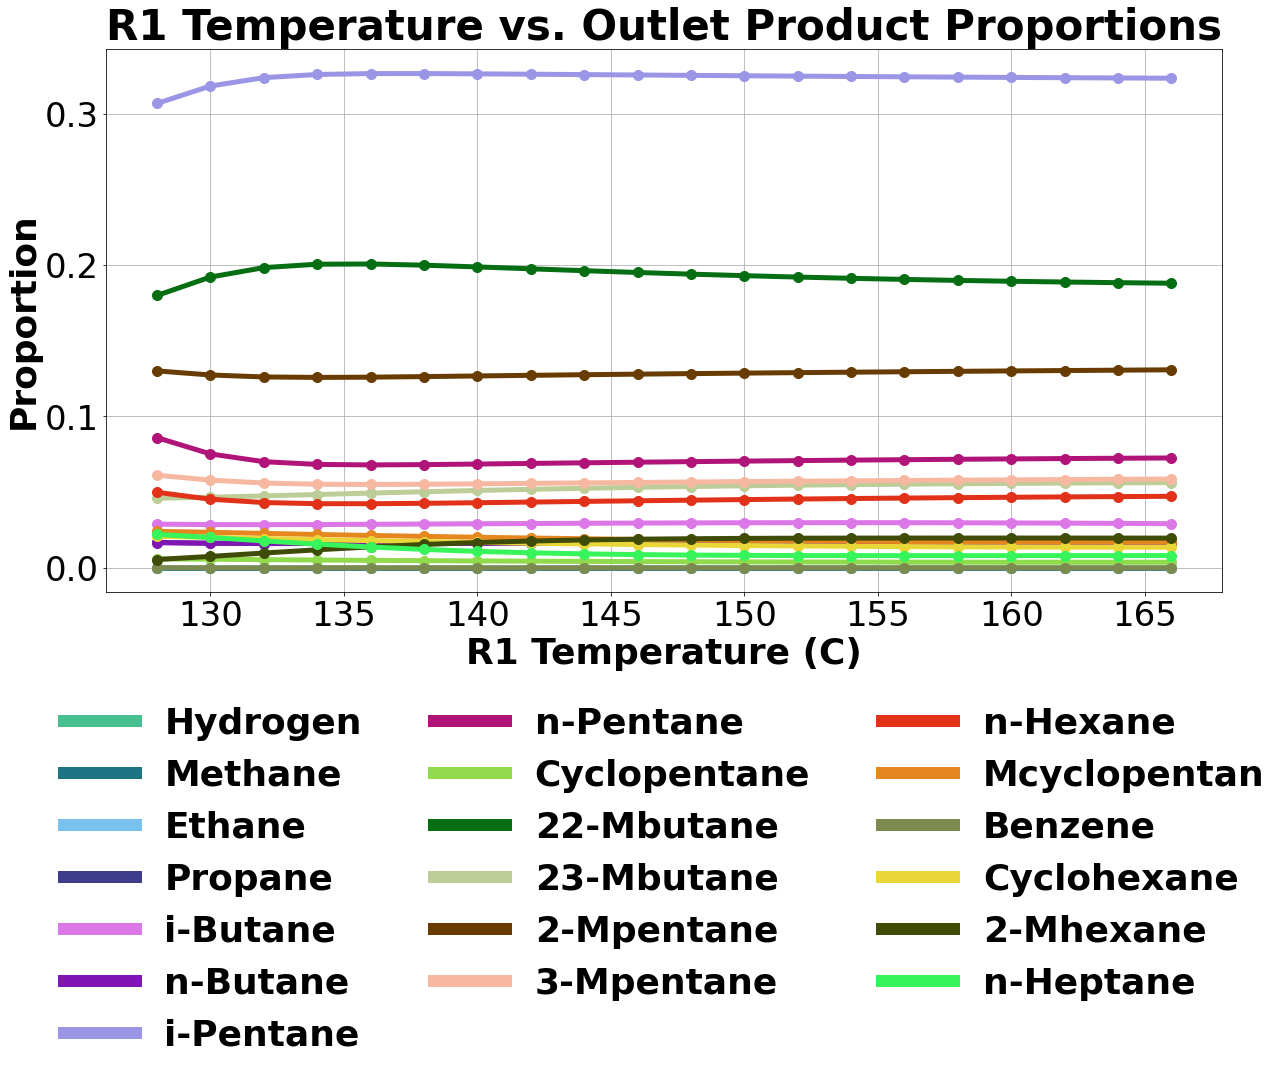

In [6]:
product_cols = [
"Hydrogen",
"Methane",
"Ethane",
"Propane",
"i-Butane",
"n-Butane",
"i-Pentane", 
"n-Pentane",
"Cyclopentane",
"22-Mbutane",
"23-Mbutane",
"2-Mpentane",
"3-Mpentane",
"n-Hexane",
"Mcyclopentan",
"Benzene",
"Cyclohexane",
"2-Mhexane",
"n-Heptane"]
product_colors = ["#48bf8e", "#1d7583", "#79c1ef", "#3e3c8d", "#db77e6", "#8115b4", "#9a95e5", "#b11478", "#91da4d", "#056e12", "#bccd97", "#683c00", "#f7b8a2", "#e13219", "#e6861f", "#7c8a4f", "#e9d737", "#3f4c08", "#36f459"]

f, ax = plt.subplots(1, 1, figsize=(20, 10))
for col, color in zip(product_cols, product_colors):
    ax.plot(sdf['r1_temp'], sdf['process_%s' % col], linewidth=5, marker='o', markersize=10, label=col, color=color)

ax.tick_params(axis='x', labelsize=34)
ax.tick_params(axis='y', labelsize=34)
ax.set_xlabel('R1 Temperature (C)', fontsize=36, fontweight='bold')
ax.set_ylabel('Proportion', fontsize=36, fontweight='bold')
ax.grid('both')
legend = ax.legend(loc='upper center', 
                  frameon=False,
                  bbox_to_anchor=(0.5, -.15),
                  fancybox=False, 
                  shadow=False,
                  ncol=3,
                  prop={'weight':'bold', 'size':36})
for line in legend.get_lines():
    line.set_linewidth(12.0)
ax.set_title('R1 Temperature vs. Outlet Product Proportions', fontsize=42, fontweight='bold')
plt.savefig("tmp/fig4.tiff", bbox_inches='tight', transparent=True, pad_inches=0, dpi=300, pil_kwargs={"compression": "tiff_lzw"})

# R1 and R2 on Output Concentrations

[128.0, 130.0, 132.0, 134.0, 136.0, 138.0, 140.0, 142.0, 144.0, 146.0, 148.0, 150.0, 152.0, 154.0, 156.0, 158.0, 160.0, 162.0, 164.0, 166.0]
[128.0, 130.0, 132.0, 134.0, 136.0, 138.0, 140.0, 142.0, 144.0, 146.0, 148.0, 150.0, 152.0, 154.0, 156.0, 158.0, 160.0, 162.0, 164.0, 166.0]


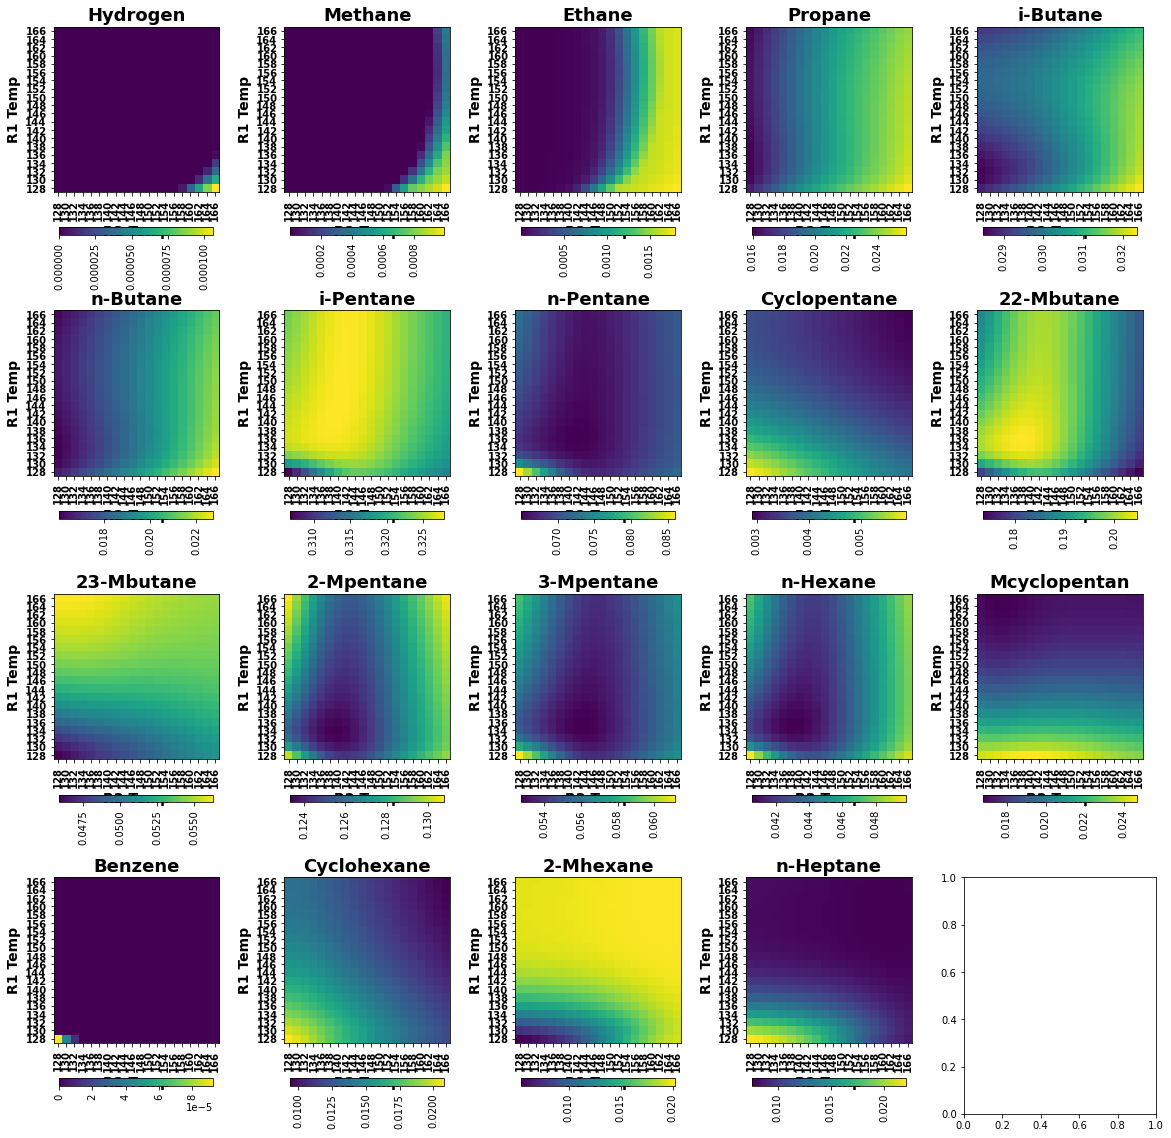

In [7]:
ix = (dfe['r1_pressure'] == 50) & (dfe['r2_pressure'] == 50)
limited_df = dfe[ix]

r1s = sorted(set(limited_df['r1_temp']))
r2s = sorted(set(limited_df['r2_temp']))
print(r1s)
print(r2s)
f, axes = plt.subplots(4, 5, figsize=(20, 20))
axes = axes.flatten()

for k, product_col in enumerate(product_cols):
    dependent_var = 'process_%s' % product_col

    M = np.zeros((len(r1s), len(r2s)))
    for i, r1t in enumerate(r1s):
        for j, r2t in enumerate(r2s):
            celldf = limited_df[(limited_df['r1_temp'] == r1t) & (limited_df['r2_temp'] == r2t)]
            mean_dep = np.mean(celldf[dependent_var])
            M[i, j] = mean_dep
    
    n,m = M.shape
    
    ax = axes[k]
        
    im = ax.imshow(M, origin='lower')

    ax.set_xticks(np.arange(m))
    ax.set_xticklabels(['%d' % d for d in r2s], rotation=90, fontsize=10, fontweight='bold')
    ax.set_yticks(np.arange(n))
    ax.set_yticklabels(['%d' % d for d in r1s], fontsize=10, fontweight='bold')
    ax.set_xlabel('R2 Temp', fontsize=14, fontweight='bold')
    ax.set_ylabel('R1 Temp', fontsize=14, fontweight='bold')
    cbar = f.colorbar(im, ax=ax, shrink=0.8, orientation='horizontal')
    
    cbar.ax.tick_params(labelsize=10, rotation=90) 
    ax.set_title(product_col, fontsize=18, fontweight='bold')

# Spearman Correlations of Process Products

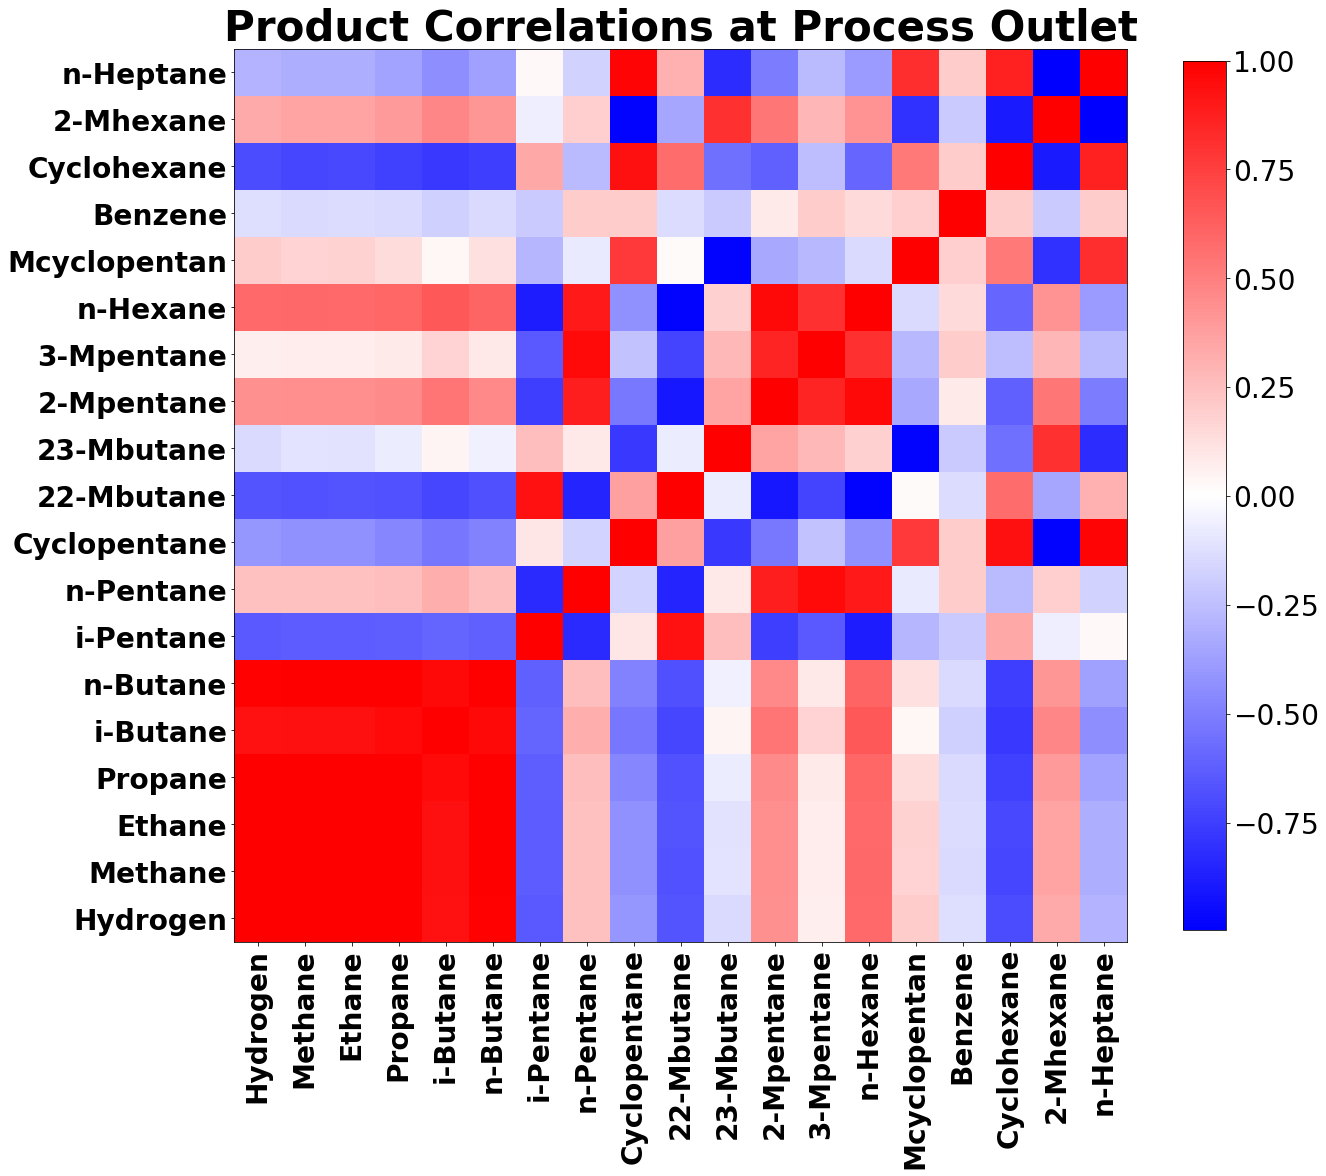

In [8]:
product_cols = [
"Hydrogen",
"Methane",
"Ethane",
"Propane",
"i-Butane",
"n-Butane",
"i-Pentane", 
"n-Pentane",
"Cyclopentane",
"22-Mbutane",
"23-Mbutane",
"2-Mpentane",
"3-Mpentane",
"n-Hexane",
"Mcyclopentan",
"Benzene",
"Cyclohexane",
"2-Mhexane",
"n-Heptane"]

for outlet in ['process']:
    actual_cols = ["%s_%s" % (outlet, c) for c in product_cols]
    
#     Z = rng.random((df.shape[0], len(product_cols)))
#     Z = np.exp(Z) / np.sum(np.exp(Z), axis=1, keepdims=True)
#     df[actual_cols] = Z
    corr_mat = dfe[actual_cols].corr('spearman')
    n = len(actual_cols)

    f, ax = plt.subplots(1, 1, figsize=(20, 20))
    im = ax.imshow(corr_mat, origin='lower', cmap='bwr')
    ax.set_xticks(np.arange(n))
    ax.set_xticklabels(product_cols, rotation=90, fontsize=28, fontweight='bold')
    ax.set_yticks(np.arange(n))
    ax.set_yticklabels(product_cols, fontsize=28, fontweight='bold')
    cbar = f.colorbar(im, ax=ax, shrink=0.8)
    cbar.ax.tick_params(labelsize=28) 
    ax.set_title("Product Correlations at Process Outlet", fontsize=42, fontweight='bold')
plt.savefig("tmp/fig5.tiff", bbox_inches='tight', transparent=True, pad_inches=0, dpi=300, pil_kwargs={"compression": "tiff_lzw"})

# Globally optimize targets

In [9]:
target_cols = ['process_ron', 'process_yield', 'r1_charge_heater']
target_modes = [np.argmax, np.argmax, np.argmin]

monitored_cols = target_cols + ['r1_temp', 'r1_pressure', 'r2_temp', 'r2_pressure']

ffdf = dfe[dfe['r1_charge_heater'] >= 0]

ixs = []
for target_col, target_mode in zip(target_cols, target_modes):
    ix_best = target_mode(ffdf[target_col])
    ixs.append(ix_best)

global_sol = ffdf.iloc[ixs][monitored_cols].copy()
global_sol.index = target_cols
global_sol.index.rename('optimization target', inplace=True)
global_sol['optimization mode'] = [tm.__name__.replace('arg','') for tm in target_modes]
global_sol = global_sol[['optimization mode'] + list(global_sol.columns)[:-1]]
global_sol['r1_charge_heater'] /= 1000000
global_sol.round(3)

,optimization mode,process_ron,process_yield,r1_charge_heater,r1_temp,r1_pressure,r2_temp,r2_pressure
optimization target,,,,,,,,
process_ron,max,83.775,97.763,3.380,138.0,50.0,142.0,70.0
process_yield,max,83.224,98.195,0.051,132.0,90.0,128.0,90.0
r1_charge_heater,min,83.246,98.183,0.005,132.0,60.0,128.0,60.0


In [10]:
np.max(dfe['process_ron'])

83.7753274087833

In [11]:
global_sol.to_excel("tmp/global_optima.xlsx")

In [12]:
max_ron = np.max(global_sol['process_ron'])
max_yield = np.max(global_sol['process_yield'])
min_ch = np.min(global_sol['r1_charge_heater'])

global_sol['ron_loss'] = (max_ron - global_sol['process_ron']) * 100 / max_ron
global_sol['yield_loss'] = (max_yield - global_sol['process_yield']) * 100 / max_yield
global_sol['ch_loss'] = global_sol['r1_charge_heater']/ min_ch
global_sol.round(2)

,optimization mode,process_ron,process_yield,r1_charge_heater,r1_temp,r1_pressure,r2_temp,r2_pressure,ron_loss,yield_loss,ch_loss
optimization target,,,,,,,,,,,
process_ron,max,83.78,97.76,3.38,138.0,50.0,142.0,70.0,0.00,0.44,679.62
process_yield,max,83.22,98.19,0.05,132.0,90.0,128.0,90.0,0.66,0.00,10.18
r1_charge_heater,min,83.25,98.18,0.00,132.0,60.0,128.0,60.0,0.63,0.01,1.00


# Effect of R1 and R2 on Process RON

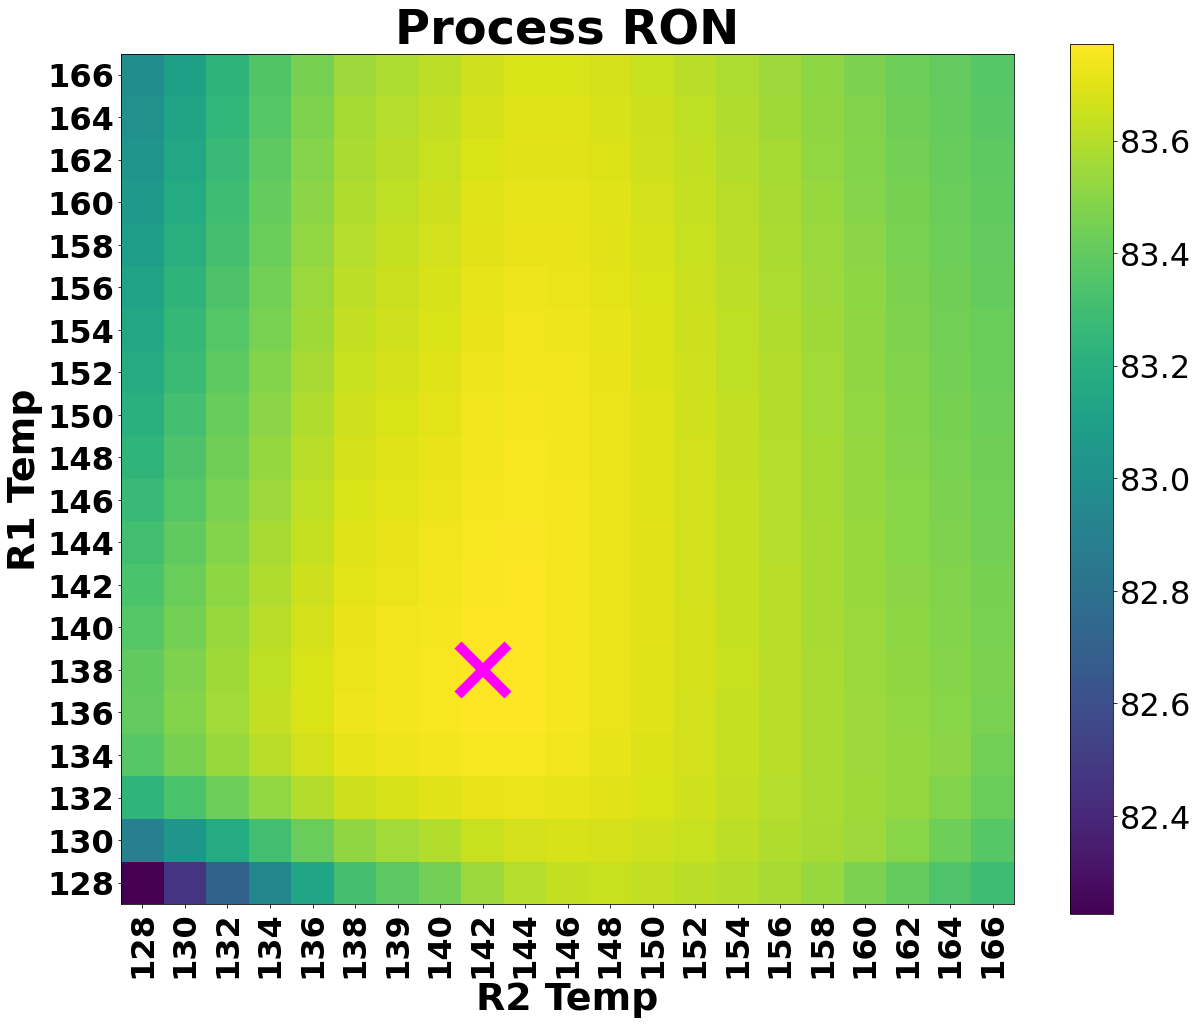

In [13]:
r1s = sorted(set(dfe['r1_temp']))
r2s = sorted(set(dfe['r2_temp']))
dependent_var = 'process_ron'

M = np.zeros((len(r1s), len(r2s)))
for i, r1t in enumerate(r1s):
    for j, r2t in enumerate(r2s):
        sdf = dfe[(dfe['r1_temp'] == r1t) & (dfe['r2_temp'] == r2t)]
        mean_dep = np.mean(sdf[dependent_var])
        M[i, j] = mean_dep

n,m = M.shape

r1t, r2t = global_sol.loc['process_ron', 'r1_temp'], global_sol.loc['process_ron', 'r2_temp']
mi = r1s.index(r1t)
mj = r2s.index(r2t)

f, ax = plt.subplots(1, 1, figsize=(20, 20))
im = ax.imshow(M, origin='lower')
ax.set_xticks(np.arange(m))
ax.set_xticklabels(['%d' % d for d in r2s], rotation=90, fontsize=32, fontweight='bold')
ax.set_yticks(np.arange(n))
ax.set_yticklabels(['%d' % d for d in r1s], fontsize=32, fontweight='bold')
ax.set_xlabel('R2 Temp', fontsize=38, fontweight='bold')
ax.set_ylabel('R1 Temp', fontsize=38, fontweight='bold')
cbar = f.colorbar(im, ax=ax, shrink=0.8)
cbar.ax.tick_params(labelsize=32) 
ax.set_title('Process RON', fontsize=48, fontweight='bold')
ax.plot(mj, mi, markersize=50, marker='x', color='magenta', markeredgewidth=10)
plt.savefig("tmp/fig7_ron.tiff", bbox_inches='tight', transparent=True, pad_inches=0, dpi=300, pil_kwargs={"compression": "tiff_lzw"})


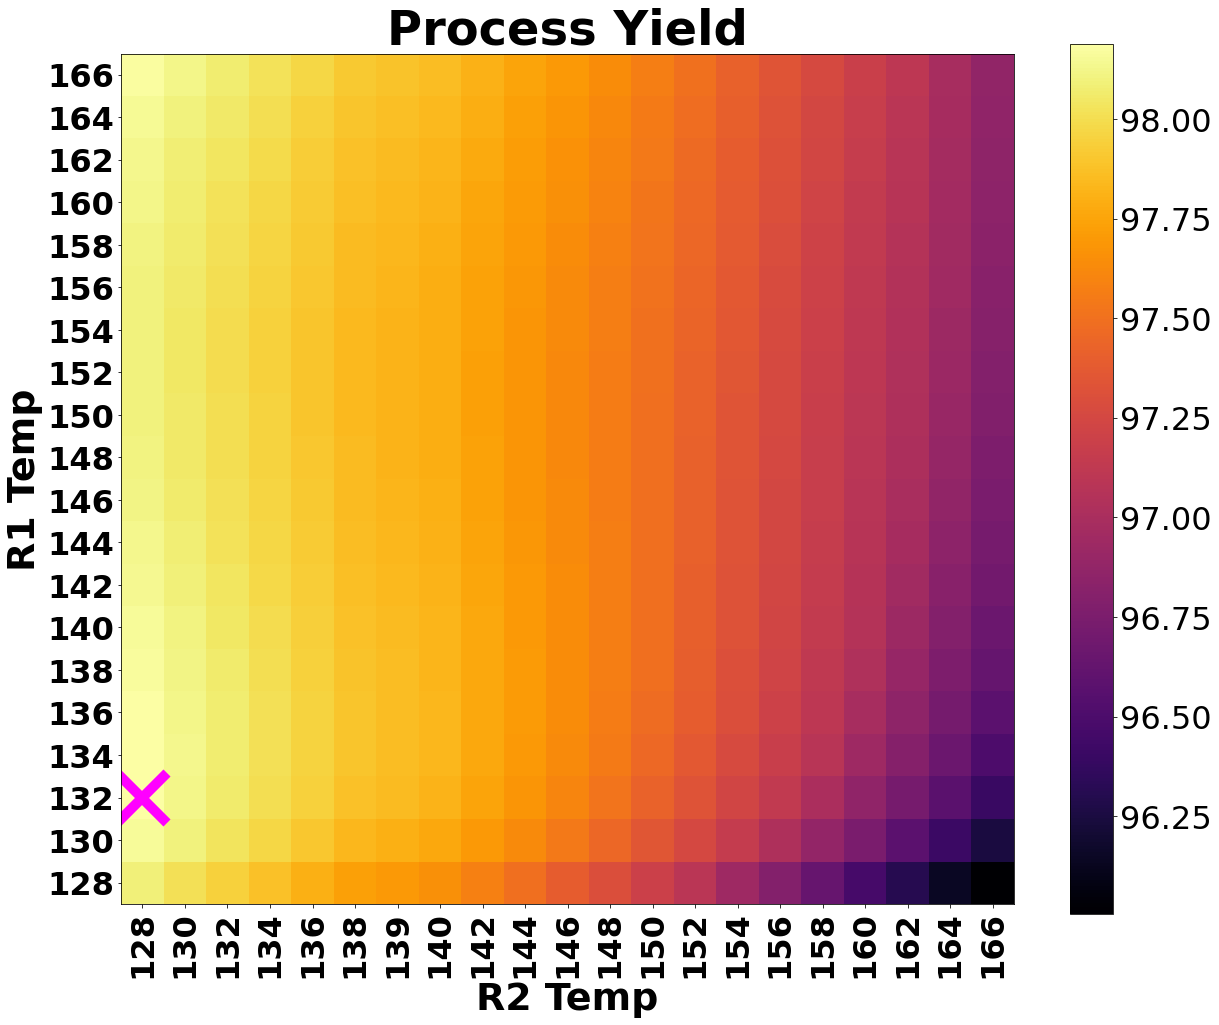

In [14]:
r1s = sorted(set(dfe['r1_temp']))
r2s = sorted(set(dfe['r2_temp']))
dependent_var = 'process_yield'

M = np.zeros((len(r1s), len(r2s)))
for i, r1t in enumerate(r1s):
    for j, r2t in enumerate(r2s):
        sdf = dfe[(dfe['r1_temp'] == r1t) & (dfe['r2_temp'] == r2t)]
        mean_dep = np.mean(sdf[dependent_var])
        M[i, j] = mean_dep

n,m = M.shape

r1t, r2t = global_sol.loc['process_yield', 'r1_temp'], global_sol.loc['process_yield', 'r2_temp']
mi = r1s.index(r1t)
mj = r2s.index(r2t)

f, ax = plt.subplots(1, 1, figsize=(20, 20))
im = ax.imshow(M, origin='lower', cmap='inferno')
ax.set_xticks(np.arange(m))
ax.set_xticklabels(['%d' % d for d in r2s], rotation=90, fontsize=32, fontweight='bold')
ax.set_yticks(np.arange(n))
ax.set_yticklabels(['%d' % d for d in r1s], fontsize=32, fontweight='bold')
ax.set_xlabel('R2 Temp', fontsize=38, fontweight='bold')
ax.set_ylabel('R1 Temp', fontsize=38, fontweight='bold')
cbar = f.colorbar(im, ax=ax, shrink=0.8)
cbar.ax.tick_params(labelsize=32) 
ax.set_title('Process Yield', fontsize=48, fontweight='bold')

ax.plot(mj, mi, markersize=50, marker='x', color='magenta', markeredgewidth=10)

plt.savefig("tmp/fig7_yield.tiff", bbox_inches='tight', transparent=True, pad_inches=0, dpi=300, 
           pil_kwargs={"compression": "tiff_lzw"})


41


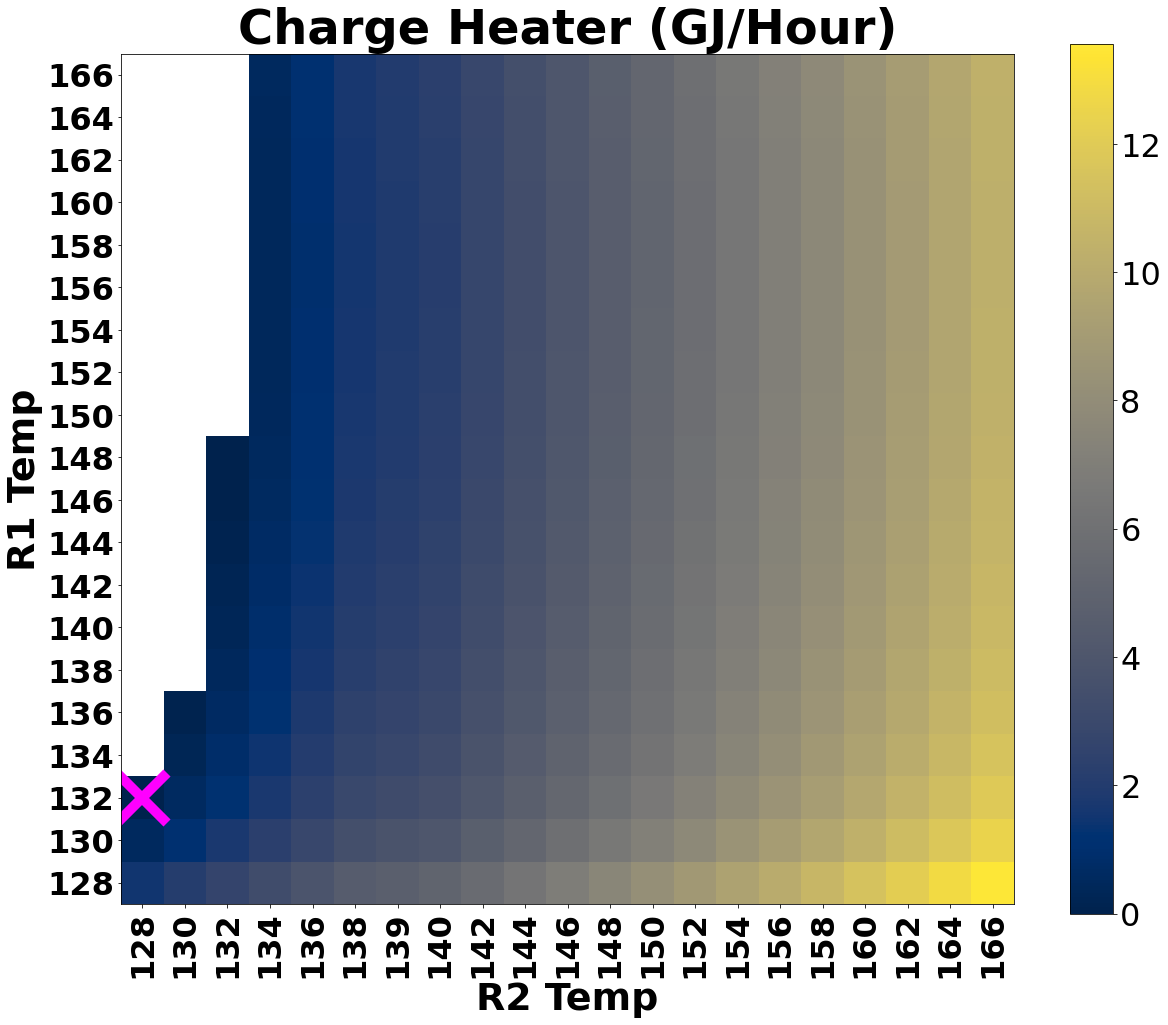

In [15]:
r1s = sorted(set(dfe['r1_temp']))
r2s = sorted(set(dfe['r2_temp']))
dependent_var = 'r1_charge_heater'

M = np.zeros((len(r1s), len(r2s)))
for i, r1t in enumerate(r1s):
    for j, r2t in enumerate(r2s):
        sdf = dfe[(dfe['r1_temp'] == r1t) & (dfe['r2_temp'] == r2t) & (dfe['r1_charge_heater'] >= 0)]
        mean_dep = np.mean(sdf[dependent_var])
        M[i, j] = mean_dep

print(np.sum(np.isnan(M)))
n,m = M.shape

r1t, r2t = global_sol.loc['r1_charge_heater', 'r1_temp'], global_sol.loc['r1_charge_heater', 'r2_temp']
mi = r1s.index(r1t)
mj = r2s.index(r2t)

M = M / (1000*1000)
f, ax = plt.subplots(1, 1, figsize=(20, 20))
im = ax.imshow(M, origin='lower', vmin=0, cmap='cividis')
ax.set_xticks(np.arange(m))
ax.set_xticklabels(['%d' % d for d in r2s], rotation=90, fontsize=32, fontweight='bold')
ax.set_yticks(np.arange(n))
ax.set_yticklabels(['%d' % d for d in r1s], fontsize=32, fontweight='bold')
ax.set_xlabel('R2 Temp', fontsize=38, fontweight='bold')
ax.set_ylabel('R1 Temp', fontsize=38, fontweight='bold')
cbar = f.colorbar(im, ax=ax, shrink=0.8)
cbar.ax.tick_params(labelsize=32) 

ax.set_title('Charge Heater (GJ/Hour)', fontsize=48, fontweight='bold')

ax.plot(mj, mi, markersize=50, marker='x', color='magenta', markeredgewidth=10)
plt.savefig("tmp/fig7_charge_heater.tiff", bbox_inches='tight', transparent=True, pad_inches=0, dpi=300, pil_kwargs={"compression": "tiff_lzw"})


In [16]:
from PIL import Image

im1 = Image.open('tmp/fig7_ron.tiff')
im2 = Image.open('tmp/fig7_yield.tiff')
im3 = Image.open('tmp/fig7_charge_heater.tiff')

dst = Image.new('RGB', (im1.width + im2.width + im3.width, im1.height))
dst.paste(im1, (0, 0))
dst.paste(im2, (im1.width, 0))
dst.paste(im3, (im1.width + im2.width, 0))

dst.save('tmp/fig7.tiff', compression='tiff_lzw')

# Constrained Optimization of Charge Heater

Min CH: 4972.982873


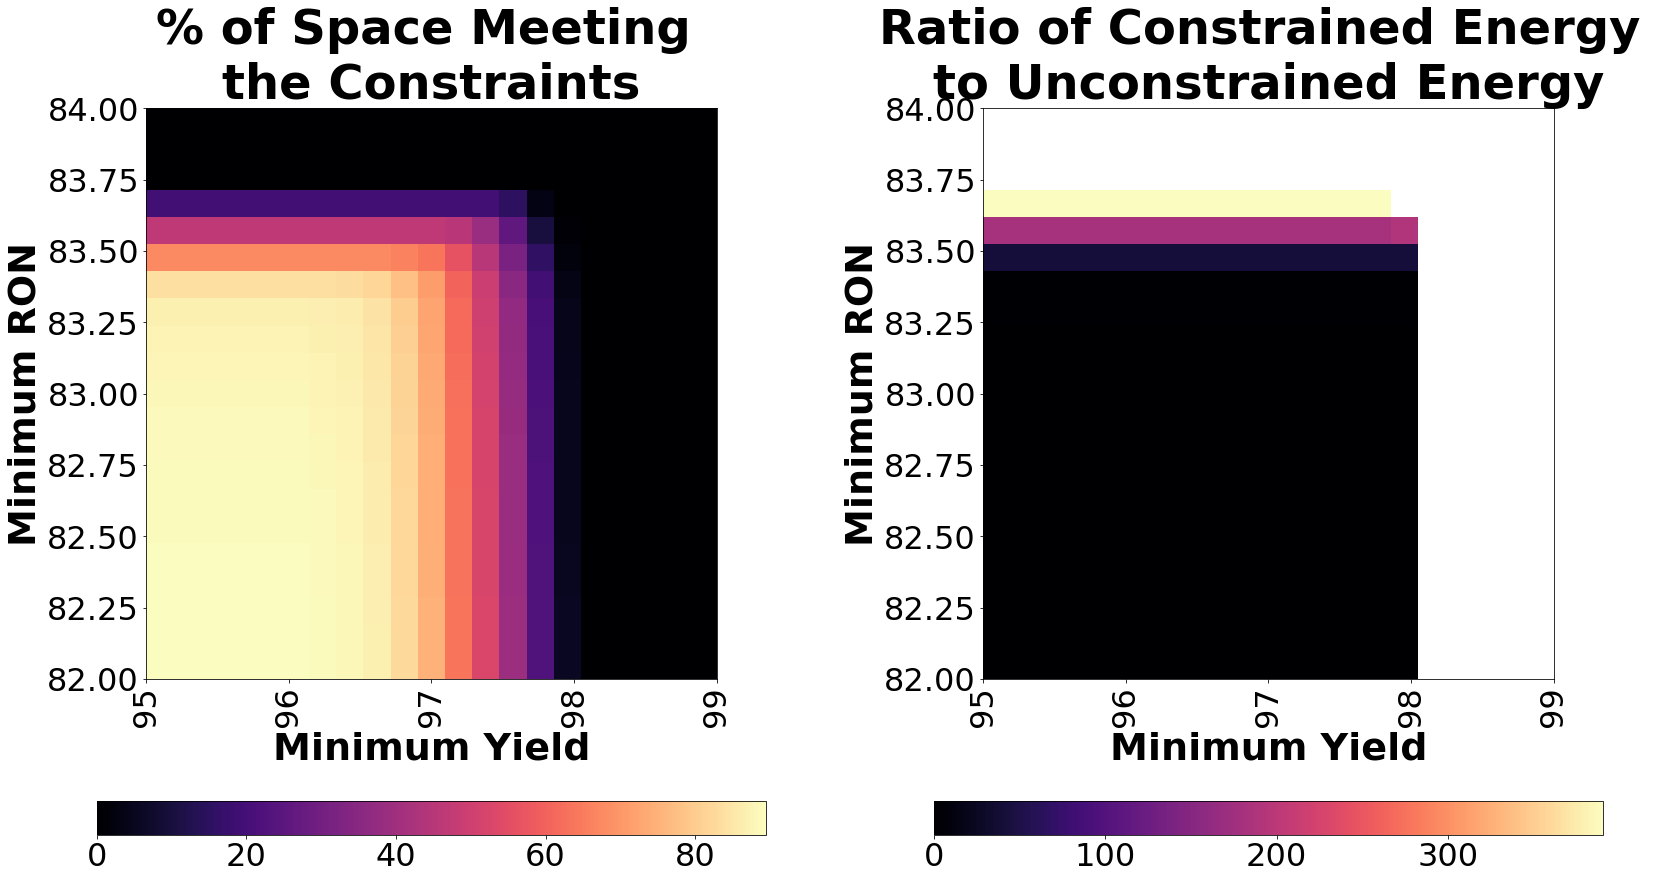

In [18]:
min_rons = np.linspace(82, 84, 21)
min_yields = np.linspace(95, 99, 21)
opt_ch = np.zeros((min_rons.shape[0], min_yields.shape[0]))
opt_size = np.zeros((min_rons.shape[0], min_yields.shape[0]))
for i in range(min_rons.shape[0]):
    for j in range(min_yields.shape[0]):
        min_ron = min_rons[i]
        min_yield = min_yields[j]
        ix = (ffdf['process_ron'] >= min_ron) & (ffdf['process_yield'] >= min_yield)
        if np.sum(ix) > 0:
            sdf = ffdf[ix]
            opt_ch[i, j] = np.min(sdf['r1_charge_heater'])
            opt_size[i, j] = np.sum(ix)
        else:
            opt_ch[i,j] = np.nan
            
min_ch = np.min(dfe[dfe['r1_charge_heater'] > 0]['r1_charge_heater'])
print("Min CH: %f" % min_ch)

f, axes = plt.subplots(1, 2, figsize=(30, 15))

ax = axes[0]
M = opt_size * 100/ dfe.shape[0]

im = ax.imshow(M, origin='lower', vmin=0, cmap='magma', extent=[95, 99, 82, 84], aspect=2)
# ax.set_xticks(np.arange(m))
# ax.set_xticklabels(['%4.2f' % d for d in min_yields], rotation=90, fontsize=32, fontweight='bold')
# ax.set_yticks(np.arange(n))
# ax.set_yticklabels(['%4.2f' % d for d in min_rons], fontsize=32, fontweight='bold')

ax.tick_params(axis='x', labelsize=32, rotation=90)
ax.tick_params(axis='y', labelsize=32)

ax.set_xlabel('Minimum Yield', fontsize=38, fontweight='bold')
ax.set_ylabel('Minimum RON', fontsize=38, fontweight='bold')
cbar = f.colorbar(im, ax=ax, shrink=0.8, orientation='horizontal')
cbar.ax.tick_params(labelsize=32) 

ax.set_title('% of Space Meeting \nthe Constraints', fontsize=48, fontweight='bold')

n,m = opt_ch.shape
M = opt_ch / min_ch

ax = axes[1]
im = ax.imshow(M, origin='lower', vmin=0, cmap='magma', extent=[95, 99, 82, 84], aspect=2)
# ax.set_xticks(np.arange(m))
# ax.set_xticklabels(['%4.2f' % d for d in min_yields], rotation=90, fontsize=32, fontweight='bold')
# ax.set_yticks(np.arange(n))
# ax.set_yticklabels(['%4.2f' % d for d in min_rons], fontsize=32, fontweight='bold')

ax.tick_params(axis='x', labelsize=32, rotation=90)
ax.tick_params(axis='y', labelsize=32)

ax.set_xlabel('Minimum Yield', fontsize=38, fontweight='bold')
ax.set_ylabel('Minimum RON', fontsize=38, fontweight='bold')
cbar = f.colorbar(im, ax=ax, shrink=0.8, orientation='horizontal')
cbar.ax.tick_params(labelsize=32) 
ax.set_title('Ratio of Constrained Energy \nto Unconstrained Energy', fontsize=48, fontweight='bold')

#f.tight_layout()
f.subplots_adjust(wspace=0)

plt.savefig("tmp/fig8.tiff", bbox_inches='tight', transparent=True, pad_inches=0, dpi=300, pil_kwargs={"compression": "tiff_lzw"})


In [19]:
M = opt_size * 100/ dfe.shape[0]

unrolled = [(min_rons[i], min_yields[j], M[i, j]) for i in range(min_rons.shape[0]) for j in range(min_yields.shape[0])]
unrolled = np.array(unrolled)
unrolled = unrolled[unrolled[:, 2] > 0, :]

ix = np.argsort(unrolled[:,2])
unrolled[ix[:20],:]

array([[83.6 , 98.  ,  0.75],
       [83.5 , 98.  ,  2.25],
       [83.7 , 97.8 ,  3.19],
       [83.4 , 98.  ,  3.55],
       [83.3 , 98.  ,  4.2 ],
       [83.2 , 98.  ,  4.4 ],
       [83.1 , 98.  ,  4.65],
       [83.  , 98.  ,  4.9 ],
       [82.9 , 98.  ,  5.  ],
       [82.7 , 98.  ,  5.15],
       [82.6 , 98.  ,  5.15],
       [82.8 , 98.  ,  5.15],
       [82.5 , 98.  ,  5.17],
       [82.4 , 98.  ,  5.4 ],
       [82.3 , 98.  ,  5.4 ],
       [82.2 , 98.  ,  5.6 ],
       [82.  , 98.  ,  5.65],
       [82.1 , 98.  ,  5.65],
       [83.6 , 97.8 , 10.28],
       [83.7 , 97.6 , 15.28]])

Text(0.5, 1.0, 'Effect of Reactor \n Temperatures on Charge Heater')

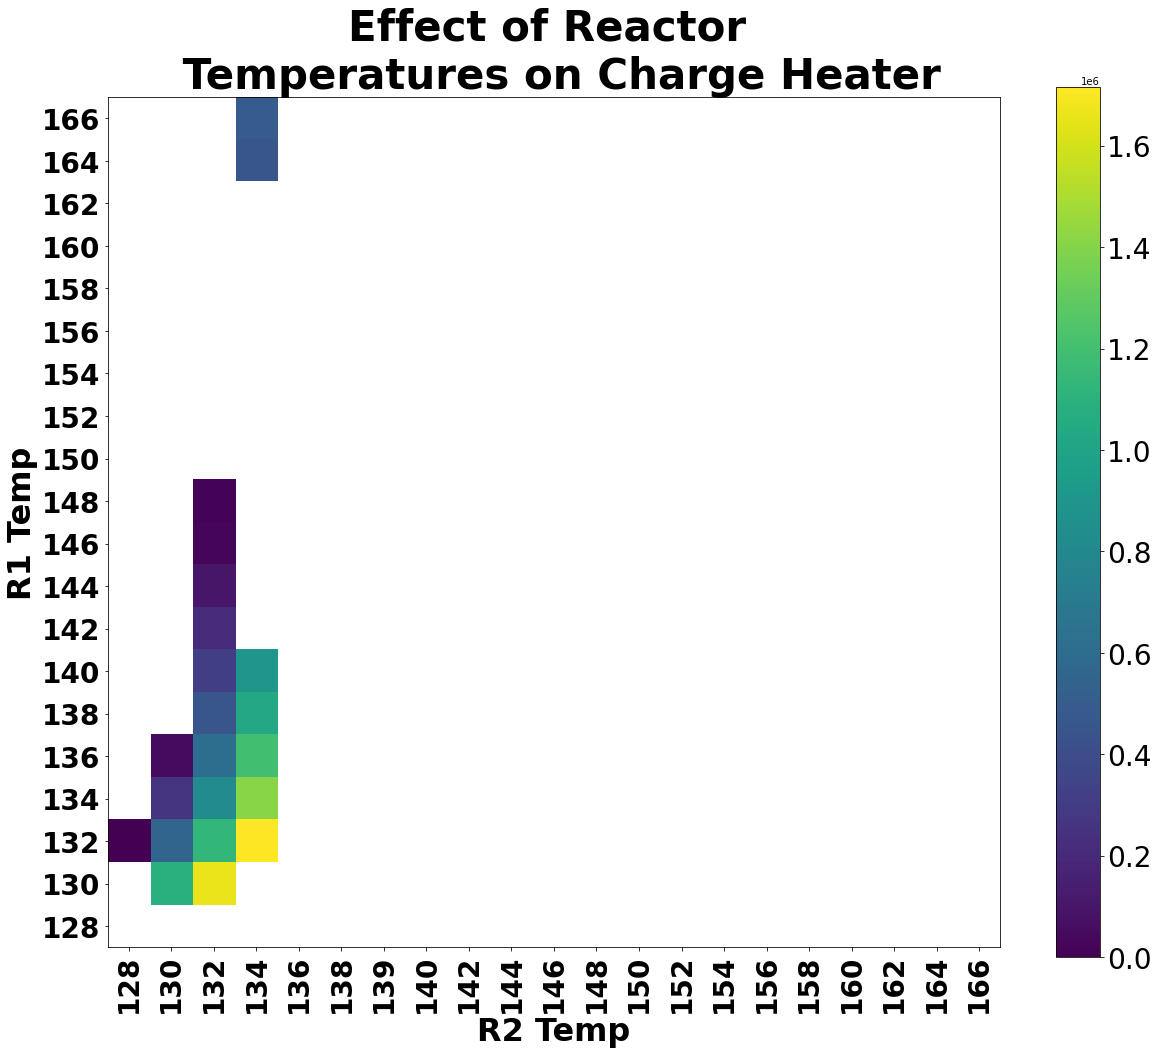

In [90]:
r1s = sorted(set(dfe['r1_temp']))
r1idxs = dict(zip(r1s, range(len(r1s))))
r2s = sorted(set(dfe['r2_temp']))
r2idxs = dict(zip(r2s, range(len(r2s))))
dependent_var = 'r1_charge_heater'

yield_var = 'process_yield'
ron_var = 'process_ron'
min_yield = 98
min_ron = 83

M = np.zeros((len(r1s), len(r2s)))
for i, r1t in enumerate(r1s):
    for j, r2t in enumerate(r2s):
        sdf = dfe[(dfe['r1_temp'] == r1t) & (dfe['r2_temp'] == r2t) & (dfe['r1_charge_heater'] >= 0)]
        mean_dep = np.min(sdf[dependent_var])
        yields = sdf[yield_var]
        rons = sdf[ron_var]
        
        if np.any((yields >= min_yield) & (rons >= min_ron)):
            #print("%f,%f" % (r1t,r2t))
            M[i, j] = mean_dep
        else:
            M[i, j] = np.nan

n,m = M.shape
f, ax = plt.subplots(1, 1, figsize=(20, 20))
im = ax.imshow(M, origin='lower', vmin=0)

ax.set_xticks(np.arange(m))
ax.set_xticklabels(['%d' % d for d in r2s], rotation=90, fontsize=28, fontweight='bold')
ax.set_yticks(np.arange(n))
ax.set_yticklabels(['%d' % d for d in r1s], fontsize=28, fontweight='bold')
ax.set_xlabel('R2 Temp', fontsize=32, fontweight='bold')
ax.set_ylabel('R1 Temp', fontsize=32, fontweight='bold')
cbar = f.colorbar(im, ax=ax, shrink=0.8)
cbar.ax.tick_params(labelsize=28) 
ax.set_title('Effect of Reactor \n Temperatures on Charge Heater', fontsize=42, fontweight='bold')

In [32]:
ix = (dfe['process_ron'] >= 83) & (dfe['process_yield'] >= 99) & (dfe['r1_charge_heater'] > 0)
np.sum(ix)


135